In [1]:
import numpy as np
import GPy
import pandas as pd
from GPy.kern import LinearSlopeBasisFuncKernel, DomainKernel, ChangePointBasisFuncKernel
from matplotlib import pyplot as plt

In [2]:
# Simulate from an OUF model
# OUF model simulation
def OUF(Tmax,beta,sigma,u0,z0,mu,gamma,dt):
    T = np.arange(0,Tmax,dt)
    n = len(T)
    u = z = n*[0]
    u[0] = u0 # set the initial value if you want to start with a different value rather than 0
    z[0] = z0
    dW = np.random.randn(n)*np.sqrt(dt) 
    for i in range(1,n):
        u[i] = u[i-1] - 1/beta*u[i-1] * dt  + sigma *dW[i]
    for i in range(1,n):
        z[i] = z[i-1] - 1/gamma*(z[i-1]-mu) * dt  + u[i]*dt
    return [u,z]    
# works

In [34]:
Tmax= 10
dt = 0.001
beta = 1
gamma =2 
sigma =1 
u0 = 0 
z0 = 0
mu = 0
z = np.array(OUF(Tmax,beta,sigma,u0,z0,mu,gamma,dt)[1])
T = np.array(np.arange(0,Tmax,dt))

In [50]:
t_column = T.reshape(-1,1)
x_column =z.reshape(-1,1)

In [51]:
t_column = t_column[::180]
x_column = x_column[::180]

In [52]:
# define the kernel again 
k1=GPy.kern.OrsteinUFnew2(1,timescale_H=2.,timescale_F=1.,sigma_H=1)
# Make a GP regression model
m1 = GPy.models.GPRegression(t_column,x_column,k1)
#_=m1.plot()

In [53]:
print(m1) 



Name : GP regression
Objective : 59.93742338979322
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  OUF.timescale_H          |    2.0  |      +ve      |        
  OUF.timescale_F          |    1.0  |      +ve      |        
  OUF.sigma_H              |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


In [54]:
m1.optimize()


In [55]:
print(m1)


Name : GP regression
Objective : -84.62374127120539
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  OUF.timescale_H          |     1.3071194935768071  |      +ve      |        
  OUF.timescale_F          |     1.3072484452518518  |      +ve      |        
  OUF.sigma_H              |     0.5115384092204965  |      +ve      |        
  Gaussian_noise.variance  |  9.638718735698683e-11  |      +ve      |        


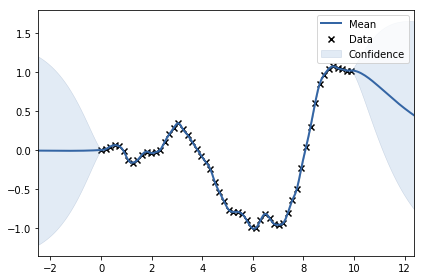

In [56]:
fig = m1.plot()

In [57]:
#Observation: even though I increase a lot the number of samples, timescale_H still doesn't go close to 1, 1.86
# this doesn't mean necesarilly that the formula is wrong, it just means the numerical approximations of the derivatives are not good enough

In [58]:
# define the kernel again 
k1=GPy.kern.OrsteinUFnew2(1,timescale_H=2.,timescale_F=1.,sigma_H=1)
# Make a GP regression model
m1 = GPy.models.GPRegression(t_column,x_column,k1)

In [59]:
print(m1)
# make sure to start from unoptimized values


Name : GP regression
Objective : 59.93742338979322
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  OUF.timescale_H          |    2.0  |      +ve      |        
  OUF.timescale_F          |    1.0  |      +ve      |        
  OUF.sigma_H              |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


In [60]:
hmc1 = GPy.inference.mcmc.HMC(m1,stepsize=5e-2)
s1 = hmc1.sample(num_samples=100)

Text(0, 0.5, 'Parameter value')

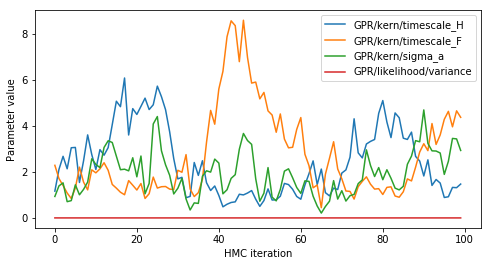

In [61]:
A1=s1
timescale_H_final_vector=[p[0] for p in A1]# variance goes first in GPy
timescale_F_final_vector=[p[1] for p in A1]
sigma_a_final_vector = [p[2] for p in A1]
likelihood_variance_final_vector = [p[3] for p in A1]
d = {'col1': timescale_H_final_vector, 'col2':timescale_F_final_vector, 'col3':sigma_a_final_vector, 'col4':likelihood_variance_final_vector}
df = pd.DataFrame(data=d)#, dtype=np.int8)
df.columns=['GPR/kern/timescale_H','GPR/kern/timescale_F','GPR/kern/sigma_a','GPR/likelihood/variance']# changing the names
samples1=df # rename it
plt.figure(figsize=(8,4))
for i, col in samples1.iteritems():
    plt.plot(col, label=col.name)
plt.legend(loc=0)
plt.xlabel('HMC iteration')
plt.ylabel('Parameter value')

In [62]:
labels = ['timescale_H', 'timescale_F','sigma_H','likelihood_variance']

Text(0, 0.5, 'timescale_H')

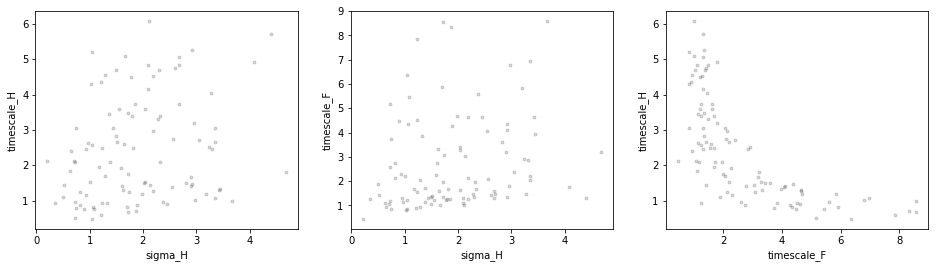

In [63]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(131)
_=ax.plot(s1[:,2],s1[:,0],'k.', alpha = 0.15)
ax.set_xlabel(labels[2]); ax.set_ylabel(labels[0])
ax = fig.add_subplot(132)
_=ax.plot(s1[:,2],s1[:,1],'k.', alpha = 0.15)
ax.set_xlabel(labels[2]); ax.set_ylabel(labels[1])
ax = fig.add_subplot(133)
_=ax.plot(s1[:,1],s1[:,0],'k.', alpha = 0.15)
ax.set_xlabel(labels[1]); ax.set_ylabel(labels[0])

Text(0, 0.5, 'likelihood_variance')

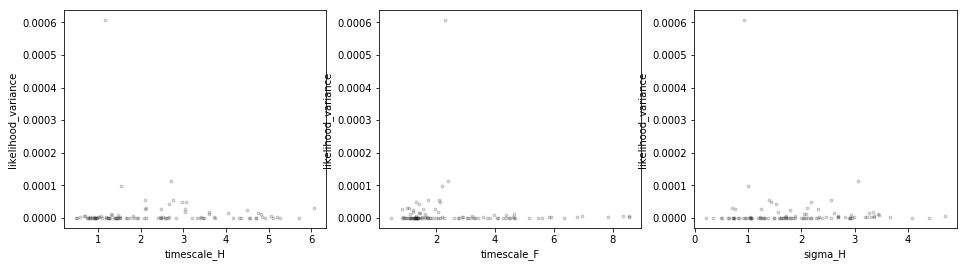

In [64]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(131)
_=ax.plot(s1[:,0],s1[:,3],'k.', alpha = 0.15)
ax.set_xlabel(labels[0]); ax.set_ylabel(labels[3])
ax = fig.add_subplot(132)
_=ax.plot(s1[:,1],s1[:,3],'k.', alpha = 0.15)
ax.set_xlabel(labels[1]); ax.set_ylabel(labels[3])
ax = fig.add_subplot(133)
_=ax.plot(s1[:,2],s1[:,3],'k.', alpha = 0.15)
ax.set_xlabel(labels[2]); ax.set_ylabel(labels[3])

In [ ]:
# Copyright (c) 2012-2014 The GPy authors (see AUTHORS.txt)
# Licensed under the BSD 3-clause license (see LICENSE.txt)
#TODO
"""
A lot of this code assumes that the link function is the identity.
I think laplace code is okay, but I'm quite sure that the EP moments will only work if the link is identity.
Furthermore, exact Guassian inference can only be done for the identity link, so we should be asserting so for all calls which relate to that.
James 11/12/13
"""

import numpy as np
from scipy import stats, special
from . import link_functions
from .likelihood import Likelihood
from ..core.parameterization import Param
from paramz.transformations import Logexp
from scipy import stats

class Gaussian(Likelihood):
    """
    Gaussian likelihood
    .. math::
        \\ln p(y_{i}|\\lambda(f_{i})) = -\\frac{N \\ln 2\\pi}{2} - \\frac{\\ln |K|}{2} - \\frac{(y_{i} - \\lambda(f_{i}))^{T}\\sigma^{-2}(y_{i} - \\lambda(f_{i}))}{2}
    :param variance: variance value of the Gaussian distribution
    :param N: Number of data points
    :type N: int
    """
    def __init__(self, gp_link=None, variance=1., name='Gaussian_noise'):
        if gp_link is None:
            gp_link = link_functions.Identity()

        if not isinstance(gp_link, link_functions.Identity):
            print("Warning, Exact inference is not implemeted for non-identity link functions,\
            if you are not already, ensure Laplace inference_method is used")

        super(Gaussian, self).__init__(gp_link, name=name)

        self.variance = Param('variance', variance, Logexp())
        self.link_parameter(self.variance)

        if isinstance(gp_link, link_functions.Identity):
            self.log_concave = True

    def to_dict(self):
        """
        Convert the object into a json serializable dictionary.
        Note: It uses the private method _save_to_input_dict of the parent.
        :return dict: json serializable dictionary containing the needed information to instantiate the object
        """

        input_dict = super(Gaussian, self)._save_to_input_dict()
        input_dict["class"] = "GPy.likelihoods.Gaussian"
        input_dict["variance"] = self.variance.values.tolist()
        return input_dict


    def betaY(self,Y,Y_metadata=None):
        #TODO: ~Ricardo this does not live here
        raise RuntimeError("Please notify the GPy developers, this should not happen")
        return Y/self.gaussian_variance(Y_metadata)

    def gaussian_variance(self, Y_metadata=None):
        return self.variance

    def update_gradients(self, grad):
        self.variance.gradient = grad

    def ep_gradients(self, Y, cav_tau, cav_v, dL_dKdiag, Y_metadata=None, quad_mode='gk', boost_grad=1.):
        return self.exact_inference_gradients(dL_dKdiag)

    def exact_inference_gradients(self, dL_dKdiag, Y_metadata=None):
        return dL_dKdiag.sum()

    def _preprocess_values(self, Y):
        """
        Check if the values of the observations correspond to the values
        assumed by the likelihood function.
        """
        return Y

    def moments_match_ep(self, data_i, tau_i, v_i, Y_metadata_i=None):
        """
        Moments match of the marginal approximation in EP algorithm
        :param i: number of observation (int)
        :param tau_i: precision of the cavity distribution (float)
        :param v_i: mean/variance of the cavity distribution (float)
        """
        sigma2_hat = 1./(1./self.variance + tau_i)
        mu_hat = sigma2_hat*(data_i/self.variance + v_i)
        sum_var = self.variance + 1./tau_i
        Z_hat = 1./np.sqrt(2.*np.pi*sum_var)*np.exp(-.5*(data_i - v_i/tau_i)**2./sum_var)
        return Z_hat, mu_hat, sigma2_hat

    def predictive_values(self, mu, var, full_cov=False, Y_metadata=None):
        if full_cov:
            if var.ndim == 2:
                var += np.eye(var.shape[0])*self.variance
            if var.ndim == 3:
                var += np.atleast_3d(np.eye(var.shape[0])*self.variance)
        else:
            var += self.variance
        return mu, var

    def predictive_mean(self, mu, sigma):
        return mu

    def predictive_variance(self, mu, sigma, predictive_mean=None):
        return self.variance + sigma**2

    def predictive_quantiles(self, mu, var, quantiles, Y_metadata=None):
        return  [stats.norm.ppf(q/100.)*np.sqrt(var + self.variance) + mu for q in quantiles]

    def pdf_link(self, link_f, y, Y_metadata=None):
        """
        Likelihood function given link(f)
        .. math::
            \\ln p(y_{i}|\\lambda(f_{i})) = -\\frac{N \\ln 2\\pi}{2} - \\frac{\\ln |K|}{2} - \\frac{(y_{i} - \\lambda(f_{i}))^{T}\\sigma^{-2}(y_{i} - \\lambda(f_{i}))}{2}
        :param link_f: latent variables link(f)
        :type link_f: Nx1 array
        :param y: data
        :type y: Nx1 array
        :param Y_metadata: Y_metadata not used in gaussian
        :returns: likelihood evaluated for this point
        :rtype: float
        """
        #Assumes no covariance, exp, sum, log for numerical stability
        return np.exp(np.sum(np.log(stats.norm.pdf(y, link_f, np.sqrt(self.variance)))))

    def logpdf_link(self, link_f, y, Y_metadata=None):
        """
        Log likelihood function given link(f)
        .. math::
            \\ln p(y_{i}|\\lambda(f_{i})) = -\\frac{N \\ln 2\\pi}{2} - \\frac{\\ln |K|}{2} - \\frac{(y_{i} - \\lambda(f_{i}))^{T}\\sigma^{-2}(y_{i} - \\lambda(f_{i}))}{2}
        :param link_f: latent variables link(f)
        :type link_f: Nx1 array
        :param y: data
        :type y: Nx1 array
        :param Y_metadata: Y_metadata not used in gaussian
        :returns: log likelihood evaluated for this point
        :rtype: float
        """
        ln_det_cov = np.log(self.variance)
        return -(1.0/(2*self.variance))*((y-link_f)**2) - 0.5*ln_det_cov - 0.5*np.log(2.*np.pi)

    def dlogpdf_dlink(self, link_f, y, Y_metadata=None):
        """
        Gradient of the pdf at y, given link(f) w.r.t link(f)
        .. math::
            \\frac{d \\ln p(y_{i}|\\lambda(f_{i}))}{d\\lambda(f)} = \\frac{1}{\\sigma^{2}}(y_{i} - \\lambda(f_{i}))
        :param link_f: latent variables link(f)
        :type link_f: Nx1 array
        :param y: data
        :type y: Nx1 array
        :param Y_metadata: Y_metadata not used in gaussian
        :returns: gradient of log likelihood evaluated at points link(f)
        :rtype: Nx1 array
        """
        s2_i = 1.0/self.variance
        grad = s2_i*y - s2_i*link_f
        return grad

    def d2logpdf_dlink2(self, link_f, y, Y_metadata=None):
        """
        Hessian at y, given link_f, w.r.t link_f.
        i.e. second derivative logpdf at y given link(f_i) link(f_j)  w.r.t link(f_i) and link(f_j)
        The hessian will be 0 unless i == j
        .. math::
            \\frac{d^{2} \\ln p(y_{i}|\\lambda(f_{i}))}{d^{2}f} = -\\frac{1}{\\sigma^{2}}
        :param link_f: latent variables link(f)
        :type link_f: Nx1 array
        :param y: data
        :type y: Nx1 array
        :param Y_metadata: Y_metadata not used in gaussian
        :returns: Diagonal of log hessian matrix (second derivative of log likelihood evaluated at points link(f))
        :rtype: Nx1 array
        .. Note::
            Will return diagonal of hessian, since every where else it is 0, as the likelihood factorizes over cases
            (the distribution for y_i depends only on link(f_i) not on link(f_(j!=i))
        """
        N = y.shape[0]
        D = link_f.shape[1]
        hess = -(1.0/self.variance)*np.ones((N, D))
        return hess

    def d3logpdf_dlink3(self, link_f, y, Y_metadata=None):
        """
        Third order derivative log-likelihood function at y given link(f) w.r.t link(f)
        .. math::
            \\frac{d^{3} \\ln p(y_{i}|\\lambda(f_{i}))}{d^{3}\\lambda(f)} = 0
        :param link_f: latent variables link(f)
        :type link_f: Nx1 array
        :param y: data
        :type y: Nx1 array
        :param Y_metadata: Y_metadata not used in gaussian
        :returns: third derivative of log likelihood evaluated at points link(f)
        :rtype: Nx1 array
        """
        N = y.shape[0]
        D = link_f.shape[1]
        d3logpdf_dlink3 = np.zeros((N,D))
        return d3logpdf_dlink3

    def dlogpdf_link_dvar(self, link_f, y, Y_metadata=None):
        """
        Gradient of the log-likelihood function at y given link(f), w.r.t variance parameter (noise_variance)
        .. math::
            \\frac{d \\ln p(y_{i}|\\lambda(f_{i}))}{d\\sigma^{2}} = -\\frac{N}{2\\sigma^{2}} + \\frac{(y_{i} - \\lambda(f_{i}))^{2}}{2\\sigma^{4}}
        :param link_f: latent variables link(f)
        :type link_f: Nx1 array
        :param y: data
        :type y: Nx1 array
        :param Y_metadata: Y_metadata not used in gaussian
        :returns: derivative of log likelihood evaluated at points link(f) w.r.t variance parameter
        :rtype: float
        """
        e = y - link_f
        s_4 = 1.0/(self.variance**2)
        dlik_dsigma = -0.5/self.variance + 0.5*s_4*np.square(e)
        return dlik_dsigma

    def dlogpdf_dlink_dvar(self, link_f, y, Y_metadata=None):
        """
        Derivative of the dlogpdf_dlink w.r.t variance parameter (noise_variance)
        .. math::
            \\frac{d}{d\\sigma^{2}}(\\frac{d \\ln p(y_{i}|\\lambda(f_{i}))}{d\\lambda(f)}) = \\frac{1}{\\sigma^{4}}(-y_{i} + \\lambda(f_{i}))
        :param link_f: latent variables link(f)
        :type link_f: Nx1 array
        :param y: data
        :type y: Nx1 array
        :param Y_metadata: Y_metadata not used in gaussian
        :returns: derivative of log likelihood evaluated at points link(f) w.r.t variance parameter
        :rtype: Nx1 array
        """
        s_4 = 1.0/(self.variance**2)
        dlik_grad_dsigma = -s_4*y + s_4*link_f
        return dlik_grad_dsigma

    def d2logpdf_dlink2_dvar(self, link_f, y, Y_metadata=None):
        """
        Gradient of the hessian (d2logpdf_dlink2) w.r.t variance parameter (noise_variance)
        .. math::
            \\frac{d}{d\\sigma^{2}}(\\frac{d^{2} \\ln p(y_{i}|\\lambda(f_{i}))}{d^{2}\\lambda(f)}) = \\frac{1}{\\sigma^{4}}
        :param link_f: latent variables link(f)
        :type link_f: Nx1 array
        :param y: data
        :type y: Nx1 array
        :param Y_metadata: Y_metadata not used in gaussian
        :returns: derivative of log hessian evaluated at points link(f_i) and link(f_j) w.r.t variance parameter
        :rtype: Nx1 array
        """
        s_4 = 1.0/(self.variance**2)
        N = y.shape[0]
        D = link_f.shape[1]
        d2logpdf_dlink2_dvar = np.ones((N, D))*s_4
        return d2logpdf_dlink2_dvar

    def dlogpdf_link_dtheta(self, f, y, Y_metadata=None):
        dlogpdf_dtheta = np.zeros((self.size, f.shape[0], f.shape[1]))
        dlogpdf_dtheta[0,:,:] = self.dlogpdf_link_dvar(f, y, Y_metadata=Y_metadata)
        return dlogpdf_dtheta

    def dlogpdf_dlink_dtheta(self, f, y, Y_metadata=None):
        dlogpdf_dlink_dtheta = np.zeros((self.size, f.shape[0], f.shape[1]))
        dlogpdf_dlink_dtheta[0, :, :]= self.dlogpdf_dlink_dvar(f, y, Y_metadata=Y_metadata)
        return dlogpdf_dlink_dtheta

    def d2logpdf_dlink2_dtheta(self, f, y, Y_metadata=None):
        d2logpdf_dlink2_dtheta = np.zeros((self.size, f.shape[0], f.shape[1]))
        d2logpdf_dlink2_dtheta[0, :, :] = self.d2logpdf_dlink2_dvar(f, y, Y_metadata=Y_metadata)
        return d2logpdf_dlink2_dtheta

    def _mean(self, gp):
        """
        Expected value of y under the Mass (or density) function p(y|f)
        .. math::
            E_{p(y|f)}[y]
        """
        return self.gp_link.transf(gp)

    def _variance(self, gp):
        """
        Variance of y under the Mass (or density) function p(y|f)
        .. math::
            Var_{p(y|f)}[y]
        """
        return self.variance

    def samples(self, gp, Y_metadata=None):
        """
        Returns a set of samples of observations based on a given value of the latent variable.
        :param gp: latent variable
        """
        orig_shape = gp.shape
        gp = gp.flatten()
        #orig_shape = gp.shape
        gp = gp.flatten()
        Ysim = np.array([np.random.normal(self.gp_link.transf(gpj), scale=np.sqrt(self.variance), size=1) for gpj in gp])
        return Ysim.reshape(orig_shape)

    def log_predictive_density(self, y_test, mu_star, var_star, Y_metadata=None):
        """
        assumes independence
        """
        v = var_star + self.variance
        return -0.5*np.log(2*np.pi) -0.5*np.log(v) - 0.5*np.square(y_test - mu_star)/v

    def variational_expectations(self, Y, m, v, gh_points=None, Y_metadata=None):
        if not isinstance(self.gp_link, link_functions.Identity):
            return super(Gaussian, self).variational_expectations(Y=Y, m=m, v=v, gh_points=gh_points, Y_metadata=Y_metadata)

        lik_var = float(self.variance)
        F = -0.5*np.log(2*np.pi) -0.5*np.log(lik_var) - 0.5*(np.square(Y) + np.square(m) + v - 2*m*Y)/lik_var
        dF_dmu = (Y - m)/lik_var
        dF_dv = np.ones_like(v)*(-0.5/lik_var)
        dF_dtheta = -0.5/lik_var + 0.5*(np.square(Y) + np.square(m) + v - 2*m*Y)/(lik_var**2)
        return F, dF_dmu, dF_dv, dF_dtheta.reshape(1, Y.shape[0], Y.shape[1])

class HeteroscedasticGaussian(Gaussian):
    def __init__(self, Y_metadata, gp_link=None, variance=1., name='het_Gauss'):
        if gp_link is None:
            gp_link = link_functions.Identity()

        if not isinstance(gp_link, link_functions.Identity):
            print("Warning, Exact inference is not implemeted for non-identity link functions,\
            if you are not already, ensure Laplace inference_method is used")

        super(HeteroscedasticGaussian, self).__init__(gp_link, np.ones(Y_metadata['output_index'].shape)*variance, name)

    def exact_inference_gradients(self, dL_dKdiag,Y_metadata=None):
        return dL_dKdiag[Y_metadata['output_index']]

    def gaussian_variance(self, Y_metadata=None):
        return self.variance[Y_metadata['output_index'].flatten()]

    def predictive_values(self, mu, var, full_cov=False, Y_metadata=None):
        _s = self.variance[Y_metadata['output_index'].flatten()]
        if full_cov:
            if var.ndim == 2:
                var += np.eye(var.shape[0])*_s
            if var.ndim == 3:
                var += np.atleast_3d(np.eye(var.shape[0])*_s)
        else:
            var += _s
        return mu, var

    def predictive_quantiles(self, mu, var, quantiles, Y_metadata=None):
        _s = self.variance[Y_metadata['output_index'].flatten()]
        return  [stats.norm.ppf(q/100.)*np.sqrt(var + _s) + mu for q in quantiles]

In [ ]:
def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: 
            X2 = X
        r_H = self._scaled_dist_H(X, X2)
        r_F = self._scaled_dist_F(X, X2)
        Ke = 1/(self.timescale_H - self.timescale_F) * (self.timescale_H * np.exp(-r_H) - self.timescale_F * np.exp(-r_F))
        f = self.timescale_H * np.exp(-r_H) - self.timescale_F * np.exp(-r_F)
        g = 0.5*self.sigma_a*(self.timescale_H**2) * (self.timescale_F**2)* 1/(self.timescale_H + self.timescale_F)
        dsigma = 0.5*(self.timescale_H**2) * (self.timescale_F**2)* 1/(self.timescale_H + self.timescale_F )* Ke
        Ke_prim_H = ( np.exp(-r_H) *(1+r_H) * (self.timescale_H -self.timescale_F) - f) / (self.timescale_H -self.timescale_F)**2   
        Ke_prim_F =  (-np.exp(-r_F) *(1+r_F) * (self.timescale_H -self.timescale_F) + f) / (self.timescale_H -self.timescale_F)**2
        dtimescaleH =  0.5 * self.sigma_a * (self.timescale_F**2)* (self.timescale_H**2 + 2*self.timescale_F*self.timescale_H)/(self.timescale_H + self.timescale_F)**2 * Ke + Ke_prim_H * g
        dtimescaleF = 0.5 * self.sigma_a * (self.timescale_H**2)* (self.timescale_F**2 + 2*self.timescale_F*self.timescale_H)/((self.timescale_H + self.timescale_F)**2) * Ke + Ke_prim_F * g  
        self.sigma_a.gradient = np.sum(dsigma*dL_dK)
        self.timescale_H.gradient = np.sum(dtimescaleH*dL_dK)
        self.timescale_F.gradient = np.sum(dtimescaleF*dL_dK)
